<a href="https://colab.research.google.com/github/Qind1609/ImgProcessing-Pytorch-CNN/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)


Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow
import os
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import cv2
#check cv2
cv2.__version__

'4.1.2'

#  First Model

**Pytorch**
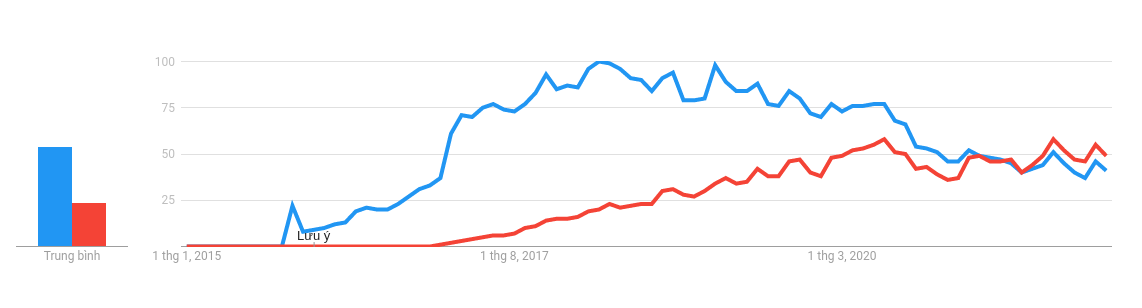

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

print(torch.__version__)

PROJ = "MyDrive/T.A/b2"

PROJECT_PATH = join(ROOT,PROJ)

print(PROJECT_PATH)

1.10.0+cu111
/content/drive/MyDrive/T.A/b2


## Setting up DataLoaders

We'll use the built-in dataset of `torchvision.datasets.ImageFolder` to quickly set up some dataloaders of downloaded cat and fish images. 

`check_image`  is a quick little function that is passed to the `is_valid_file` parameter in the ImageFolder and will do a sanity check to make sure PIL can actually open the file. We're going to use this in lieu of cleaning up the downloaded dataset.


In [ ]:
def check_image(path):
    try:
        
        im2 = Image.open(path)
        return True
    except:
        return False

**Tensor**
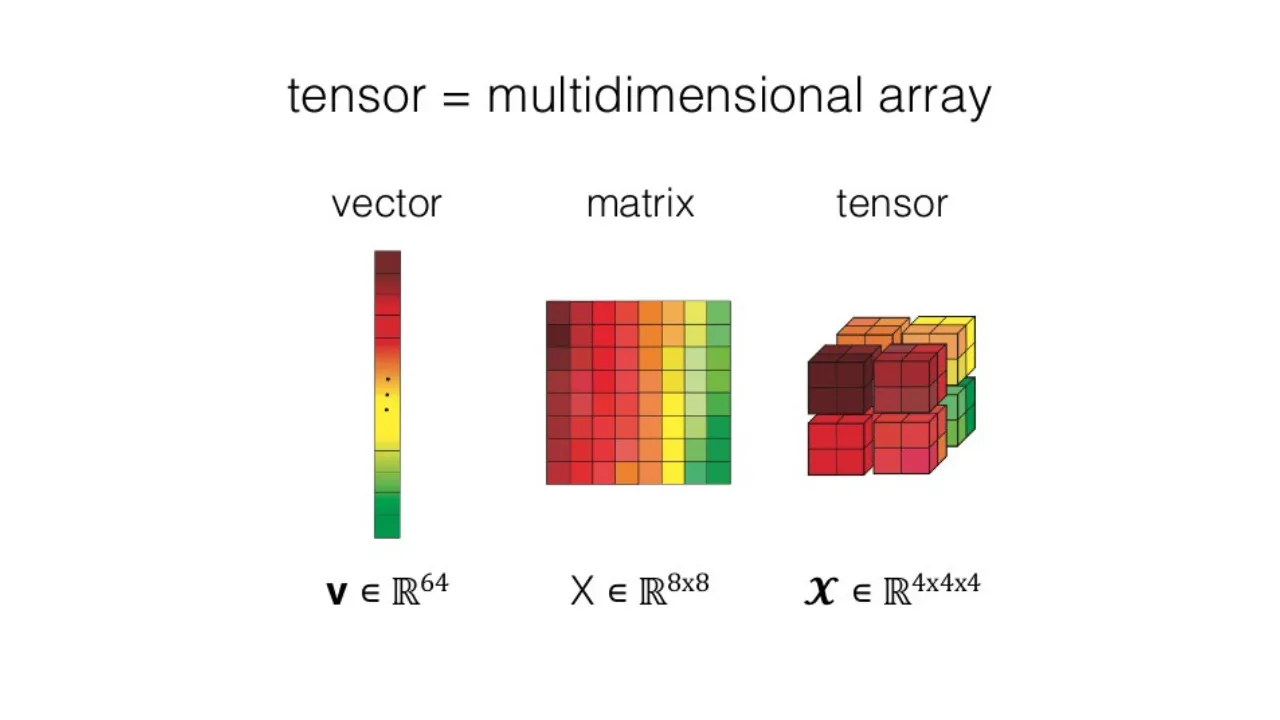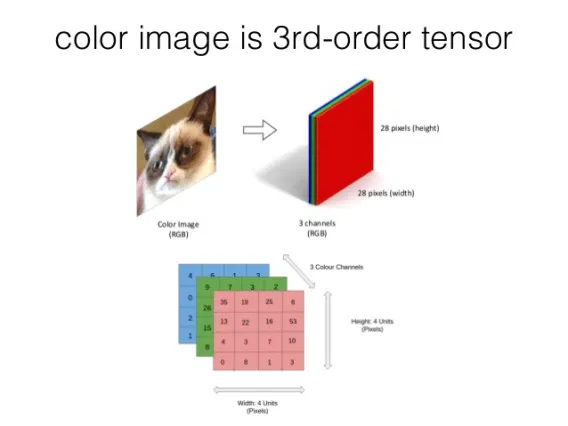

Set up the transforms for every image:

* Resize to 64x64
* Convert to tensor
* Normalize using ImageNet mean & std


In [ ]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])



**Training- Validation - Testing Set**
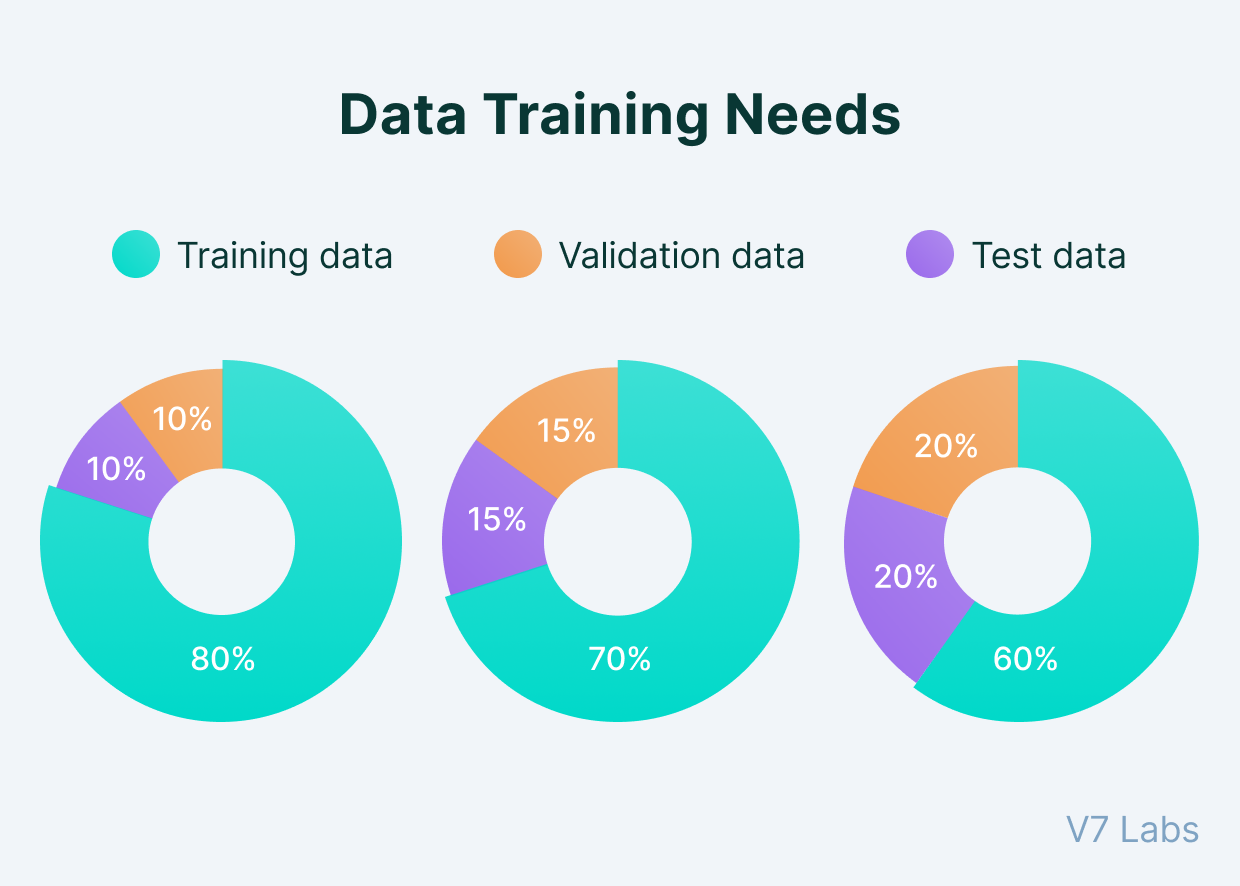

In [ ]:
train_data_path = join(PROJECT_PATH,"train")
print(train_data_path)
train_cat = join(PROJECT_PATH,"train/cat")
train_fish = join(PROJECT_PATH,"train/fish")
print("Cat image: {} images".format(len(os.listdir(train_cat)))) #print number of images in folder train/cat
print("Fish image: {} images".format(len(os.listdir(train_fish)))) #print number of images in folder train/cat
try:
  train_data = torchvision.datasets.ImageFolder(root = train_data_path,transform=img_transforms)
  print("Labelling training phase Success")
except:
  print("Labelling training phase Not Success")

/content/drive/MyDrive/T.A/b2/train
Cat image: 272 images
Fish image: 386 images
Labelling training phase Success


In [ ]:
val_data_path = "/content/drive/MyDrive/T.A/b2/val"
val_cat = r"/content/drive/MyDrive/T.A/b2/val/cat"
val_fish = r"/content/drive/MyDrive/T.A/b2/val/fish"
print("Cat image: {} images".format(len(os.listdir(val_cat)))) #print number of images in folder val/cat
print("Fish image: {} images".format(len(os.listdir(val_fish)))) #print number of images in folder val/cat
try:
  val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)
  print("Labelling validation phase Success")
except:
  print("Labelling validation phase Not Success")  

Cat image: 88 images
Fish image: 19 images
Labelling validation phase Success


In [ ]:
test_data_path = r"/content/drive/MyDrive/T.A/b2/test"
test_cat = r"/content/drive/MyDrive/T.A/b2/test/cat"
test_fish = r"/content/drive/MyDrive/T.A/b2/test/fish"
print("Cat image: {} images".format(len(os.listdir(test_cat)))) #print number of images in folder val/cat
print("Fish image: {} images".format(len(os.listdir(test_fish)))) #print number of images in folder val/cat
try:
  test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms) 
  print("Labelling testing phase Success")
except:
  print("Labelling testing phase Not Success")  

Cat image: 92 images
Fish image: 71 images
Labelling testing phase Success


In [ ]:
batch_size=25

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = False) 

## Our First Model, SimpleNet

SimpleNet is a very simple combination of three Linear layers and ReLu activations between them. Note that as we don't do a `softmax()` in our `forward()`, we will need to make sure we do it in our training function during the validation phase.

**Neural Net**

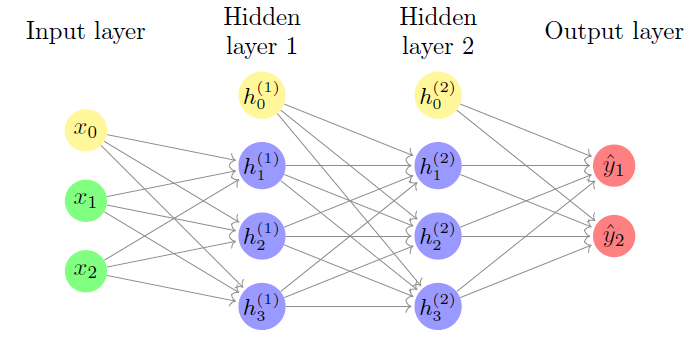

**Activation function**
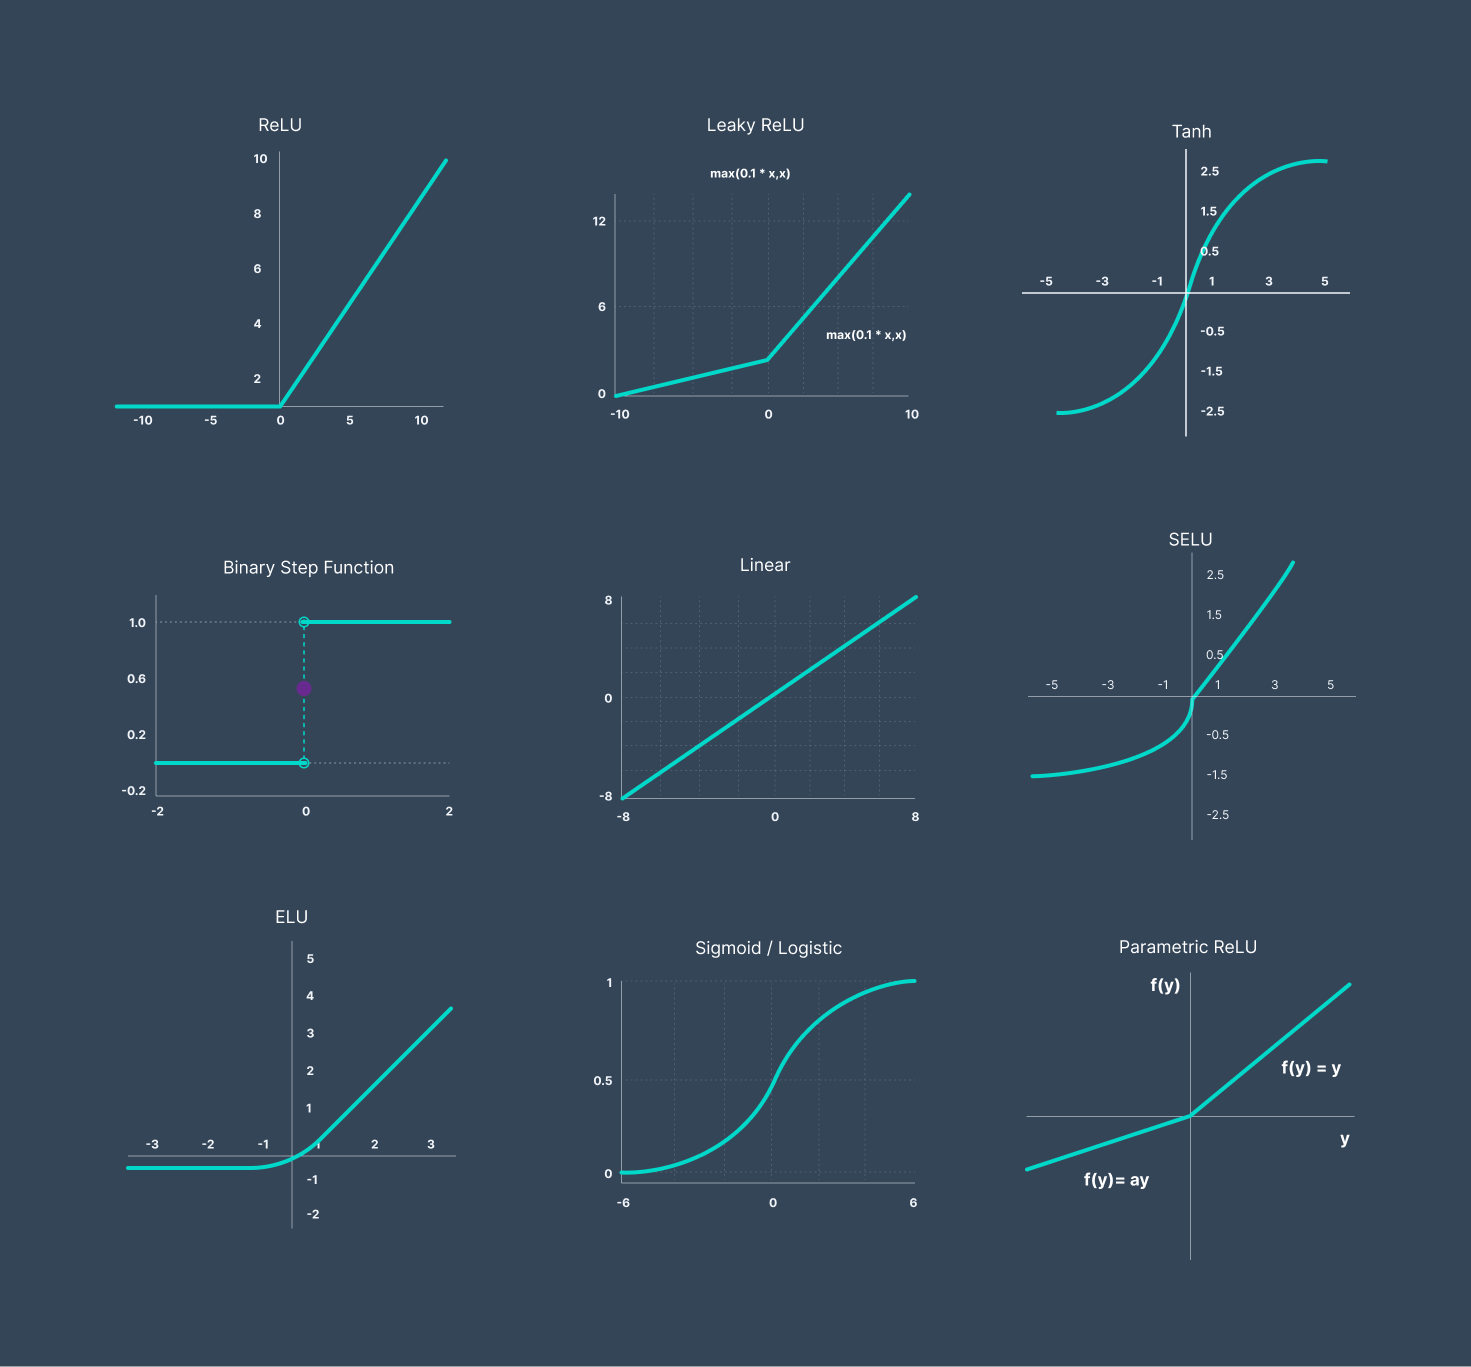

f'(x) = f(x)(1-f(x))
theta = theta - alpha * f'(x)
f'(x) = 1 - (f(x))^2

In [ ]:
class SimpleNet(nn.Module): #inherit from class nn.module

    def __init__(self):
        super(SimpleNet, self).__init__() #run init super class
        self.fc1 = nn.Linear(12288, 84) #64x64x3 input (3 channel, 64x64 pixel)
        self.fc2 = nn.Linear(84, 50) #84 node in hidden layer 1
        self.fc3 = nn.Linear(50,2) # 50 node in hidden layer 2 - 2 node in output layer (two class)
    
    # try others activation function
    def forward(self, x):
        x = x.view(-1, 12288) #flatten image 64x64x3 to 1x12288
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
simplenet = SimpleNet()

## Create an optimizer

Here, we're just using Adam as our optimizer with a learning rate of 0.001.

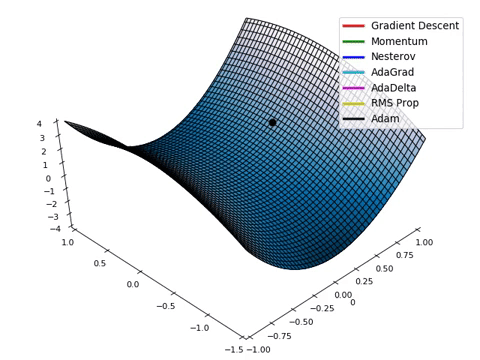

In [ ]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

# Copy the model to GPU

Copy the model to the GPU if available.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

## Training 

Trains the model, copying batches to the GPU if required, calculating losses, optimizing the network and perform validation for each epoch.

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train() #method train() inherit from super class.... set model to training mode
        for batch in train_loader: #1 batch has 25 img 64x64 with 3 color channel
            optimizer.zero_grad() #reset to gradient 0 after each loop
            inputs, targets = batch
            #target: 64-array with 0 is cat, 1 is fish
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets) #arr of loss value for every image in batch
            loss.backward() #calculate gradient of loss
            optimizer.step() #calculate parameter base on gradient above
            training_loss += loss.data.item() * inputs.size(0) #calculate sum loss for each batch .. inputs.size(0) = 64 img/batch
            # print(loss.data.item()) #mean loss each batch
        training_loss /= len(train_loader.dataset)

        
        model.eval() #set model to evaluation mode
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            #print(targets) 0 is cat 1 is fish
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0) #calculate eval-loss (sum loss each batch)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets) #feed output into softmax function
            #print(F.softmax(output, dim=1)) # probability (follow column) of each sample (img) to be cat or fish
            #print(torch.max(F.softmax(output, dim=1), dim=1)) #get indices (index) of max value (the larger probability)...
            #...in the output softmax follow which 0 is cat 1 is fish 
            #print(correct) #bolean matrix
            num_correct += torch.sum(correct).item()
            #print(num_correct)
            num_examples += correct.shape[0] #count the sample
            #print(num_examples)
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [ ]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=20, device=device)

Epoch: 1, Training Loss: 0.69, Validation Loss: 0.48, accuracy = 0.84
Epoch: 2, Training Loss: 0.44, Validation Loss: 0.61, accuracy = 0.74
Epoch: 3, Training Loss: 0.31, Validation Loss: 1.08, accuracy = 0.55
Epoch: 4, Training Loss: 0.23, Validation Loss: 0.56, accuracy = 0.76
Epoch: 5, Training Loss: 0.15, Validation Loss: 0.71, accuracy = 0.79
Epoch: 6, Training Loss: 0.13, Validation Loss: 1.39, accuracy = 0.55
Epoch: 7, Training Loss: 0.08, Validation Loss: 0.87, accuracy = 0.68
Epoch: 8, Training Loss: 0.07, Validation Loss: 1.18, accuracy = 0.65
Epoch: 9, Training Loss: 0.05, Validation Loss: 0.87, accuracy = 0.76
Epoch: 10, Training Loss: 0.03, Validation Loss: 1.02, accuracy = 0.73
Epoch: 11, Training Loss: 0.01, Validation Loss: 1.08, accuracy = 0.71
Epoch: 12, Training Loss: 0.03, Validation Loss: 1.08, accuracy = 0.75
Epoch: 13, Training Loss: 0.07, Validation Loss: 1.03, accuracy = 0.76
Epoch: 14, Training Loss: 0.12, Validation Loss: 1.84, accuracy = 0.66
Epoch: 15, Trai

## Making predictions

Labels are in alphanumeric order, so `cat` will be 0, `fish` will be 1. We'll need to transform the image and also make sure that the resulting tensor is copied to the appropriate device before applying our model to it.

**SOFTMAX**
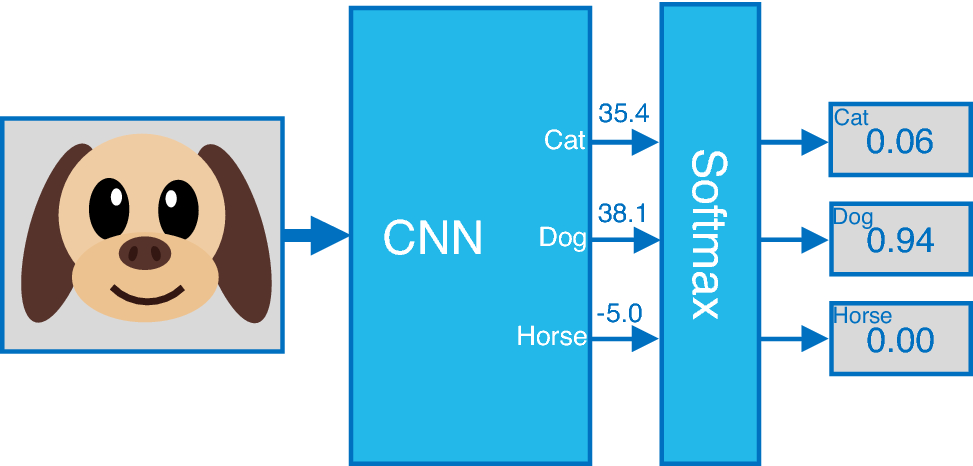

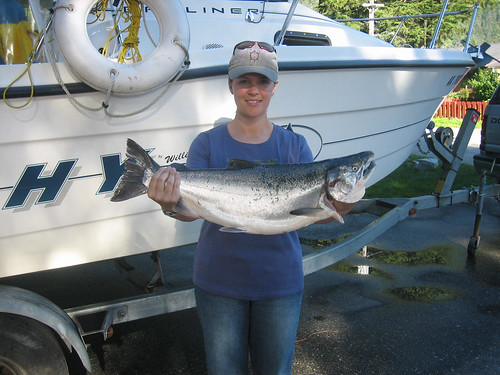

tensor([[2.9905e-10, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
fish


In [ ]:
labels = ['cat','fish']

img = Image.open("/content/drive/MyDrive/T.A/b2/test/fish/1096796892_14ad55ba7f.jpg")
display(img)
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

simplenet.eval() #evaluation mode
prediction = F.softmax(simplenet(img), dim=1) #pass img through neural network, get output and then pass through softmax function...
print(prediction) #probability to be cat (idx 0) or fish (idx 1)
prediction = prediction.argmax() #return index of max value (max probability)
print(labels[prediction]) #print the class respect to the index of max value prediction 



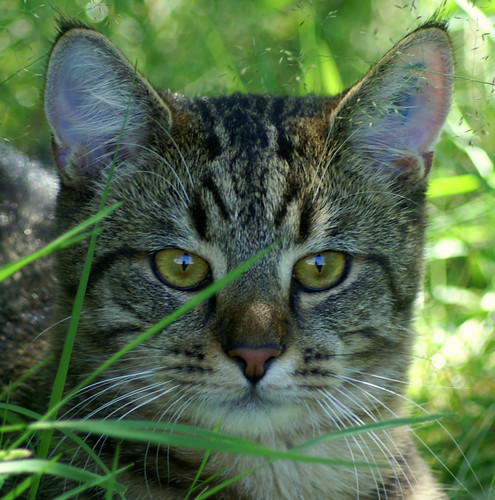

tensor([[0.2681, 0.7319]], grad_fn=<SoftmaxBackward0>)
fish


In [ ]:

img = Image.open("/content/drive/MyDrive/T.A/b2/test/cat/1129508685_d2bf1e70a5.jpg")
display(img)
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

simplenet.eval() #evaluation mode
prediction = F.softmax(simplenet(img), dim=1) #pass img through neural network, get output and then pass through softmax function...
print(prediction) #probability to be cat (idx 0) or fish (idx 1)
prediction = prediction.argmax() #return index of max value (max probability)
print(labels[prediction]) #print the class respect to the index of max value prediction 

## Saving Models

We can either save the entire model using `save` or just the parameters using `state_dict`. Using the latter is normally preferable, as it allows you to reuse parameters even if the model's structure changes (or apply parameters from one model to another).

In [ ]:
torch.save(simplenet, "/home/qind/Desktop/pytorch-learn/beginners-pytorch-deep-learning/chapter2/tmp/simplenet") 
simplenet = torch.load("/home/qind/Desktop/pytorch-learn/beginners-pytorch-deep-learning/chapter2/tmp/simplenet")    


In [ ]:
torch.save(simplenet.state_dict(), "/home/qind/Desktop/pytorch-learn/beginners-pytorch-deep-learning/chapter2/tmp/simplenet")    
simplenet = SimpleNet()
simplenet_state_dict = torch.load("/home/qind/Desktop/pytorch-learn/beginners-pytorch-deep-learning/chapter2/tmp/simplenet")
simplenet.load_state_dict(simplenet_state_dict)   

<All keys matched successfully>